In [1]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import random

from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import load_model, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector, Concatenate
from keras.optimizers import Adam
import keras

from IPython import display

from helper import *


Using TensorFlow backend.


In [2]:
raw_vedio_names = ["badboy.mp4","feel_special.mp4","kill_this_love.mp4","somi_birthday.mp4",
    "boombayah_blackpink.mp4","flower_shower.mp4","magnetic_moon_tiffany_young.mp4","sunmi_lalalay.mp4",
    "clc_me.mp4","fromis_9_fun.mp4","mamamoo_hip.mp4","swalla.mp4",
    "dumb_litty.mp4","gfriend_fever.mp4","red_velvet_umpah_umpah.mp4","vav_poison.mp4",
    "everglow_adios.mp4","gi_dle_uh_oh.mp4","red_velvet_zimzalabim.mp4","wjsn_boogie_up.mp4",
    "exid_me_and_you.mp4","jopping.mp4","snapping_chung_ha.mp4"]
vedio_names = []
for raw_vedio_name in raw_vedio_names:
    vedio_names.append(raw_vedio_name.split(".")[0])

In [3]:
x_max = 640
y_max = 360
def normalized(array):
    array = (array - [x_max / 2, y_max / 2]) / [x_max / 2, y_max / 2]
    return array

def denormalized(array):
    array = array * [x_max / 2, y_max / 2] + [x_max / 2, y_max / 2]
    return array

In [4]:
def get_normalized_flattened_position(vedio_name):
    x = np.array(get_frames(vedio_name))
    x = normalized(x)
    x_flattened = x.reshape(x.shape[0], -1)
    return x_flattened.astype(np.float32)
sample_x = get_normalized_flattened_position("badboy")

def get_feature(vedio_name):
    y = np.array(get_feature_np_array(vedio_name))
    return y.astype(np.float32)
sample_y = get_feature("badboy")

print("sample_pos array shape is ", sample_x.shape)
print("sample_feature array shape is ", sample_y.shape)

position_raw = []
feature_raw = []
random.shuffle(vedio_names)
min_input_length = 100000
for vedio_name in vedio_names:
    pos = get_normalized_flattened_position(vedio_name)
    feature = get_feature(vedio_name)
    # there are corner case that y is one frame longer than x for the different method they use to crop.
    pos = pos[:feature.shape[0], :]
    feature = feature[:pos.shape[0]]
    assert(pos.shape[0] == feature.shape[0])
    if(pos.shape[0] < min_input_length):
        min_input_length = pos.shape[0]
    position_raw.append(pos)
    feature_raw.append(feature)

sample_pos array shape is  (4131, 50)
sample_feature array shape is  (4131, 12)


In [5]:
print("cut all vedio to " + str(min_input_length))
#stack position_raw
position_raw_stacked = np.zeros((len(position_raw), min_input_length, 50))
feature_raw_stacked = np.zeros((len(position_raw), min_input_length, 12))
for i in range(len(position_raw)):
    position_raw_stacked[i, :, :] = position_raw[i][:min_input_length, :].astype(np.float32)
    feature_raw_stacked[i, :, :] = feature_raw[i][:min_input_length, :].astype(np.float32)
print(position_raw_stacked.shape)
print(feature_raw_stacked.shape)

position_raw_stacked = position_raw_stacked[:,:2000:10,:]
feature_raw_stacked = feature_raw_stacked[:,:2000:10,:]
print(position_raw_stacked.shape)
print(feature_raw_stacked.shape)

t_x = position_raw_stacked.shape[1]

cut all vedio to 2023
(23, 2023, 50)
(23, 2023, 12)
(23, 200, 50)
(23, 200, 12)


In [6]:
# Append prev position with feature and make X and Y both (, , 62)
shape_0 = position_raw_stacked.shape[0]
shape_1 = position_raw_stacked.shape[1]
X = np.zeros((shape_0, shape_1 , 62))
Y = np.zeros((shape_0, shape_1 , 62))

Y[:, 0, :] = np.concatenate([feature_raw_stacked[:, 0, :], position_raw_stacked[:, 0, :]], axis=-1)
t = 1
for t in range(shape_1):
    X[:, t, :] = np.concatenate([feature_raw_stacked[:, t, :], position_raw_stacked[:, t - 1, :]], axis=-1)
    Y[:, t, :] = np.concatenate([feature_raw_stacked[:, t, :], position_raw_stacked[:, t, :]], axis=-1)
    
# swap axis 0 and 1 for Y
Y = np.reshape(Y, (shape_1, shape_0, 62))
print(X.shape)
print(Y.shape)

(23, 200, 62)
(200, 23, 62)


In [7]:
LSTM_cell = LSTM(64, return_state = True) 
densor = Dense(50, activation='tanh')

In [8]:
def djmodel(Tx, n_a, n_values):
    # Define the input of your model with a shape 
    X = Input(shape=(Tx, n_values))

    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0

    outputs = []
    
    for t in range(Tx):
        x = Lambda(lambda x: x[:,t,:])(X)
        x = Reshape((1, n_values))(x) 
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        out = densor(a)
        outputs.append(out)
        
    model = Model(inputs=[X, a0, c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

In [9]:
model = djmodel(Tx = t_x , n_a = 64, n_values = 62)

In [10]:
opt = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='mean_squared_error')

In [11]:
a0 = np.zeros((23, 64))
c0 = np.zeros((23, 64))

In [12]:
Y = np.reshape(position_raw_stacked, (shape_1, shape_0, 50))
model.fit([X, a0, c0], list(Y), epochs=100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
23/23 [==============================] - 159s 7s/step - loss: 32.3163 - dense_1_loss: 0.1392
Epoch 2/100
23/23 [==============================] - 1s 25ms/step - loss: 137.4040 - dense_1_loss: 0.6716
Epoch 3/100
23/23 [==============================] - 1s 25ms/step - loss: 88.3374 - dense_1_loss: 0.4263
Epoch 4/100
23/23 [==============================] - 1s 25ms/step - loss: 76.0931 - dense_1_loss: 0.3706
Epoch 5/100
23/23 [==============================] - 1s 24ms/step - loss: 68.2283 - dense_1_loss: 0.3356
Epoch 6/100
23/23 [==============================] - 1s 25ms/step - loss: 55.1363 - dense_1_loss: 0.2672
Epoch 7/100
23/23 [==============================] - 1s 25ms/step - loss: 43.1036 - dense_1_loss: 0.2027
Epoch 8/100
23/23 [==============================] - 1s 25ms/step - loss: 41.4364 - dense_1_loss: 0.1942
Epoch 9/100
23/23 [==============================] - 1s 25ms/st

Epoch 71/100
23/23 [==============================] - 1s 25ms/step - loss: 10.9697 - dense_1_loss: 0.0441
Epoch 72/100
23/23 [==============================] - 1s 25ms/step - loss: 10.9346 - dense_1_loss: 0.0440
Epoch 73/100
23/23 [==============================] - 1s 24ms/step - loss: 10.9443 - dense_1_loss: 0.0441
Epoch 74/100
23/23 [==============================] - 1s 25ms/step - loss: 10.9710 - dense_1_loss: 0.0442
Epoch 75/100
23/23 [==============================] - 1s 25ms/step - loss: 10.9702 - dense_1_loss: 0.0441
Epoch 76/100
23/23 [==============================] - 1s 25ms/step - loss: 10.9407 - dense_1_loss: 0.0439
Epoch 77/100
23/23 [==============================] - 1s 25ms/step - loss: 10.9175 - dense_1_loss: 0.0437
Epoch 78/100
23/23 [==============================] - 1s 25ms/step - loss: 10.9203 - dense_1_loss: 0.0436
Epoch 79/100
23/23 [==============================] - 1s 24ms/step - loss: 10.9348 - dense_1_loss: 0.0437
Epoch 80/100
23/23 [==========================

In [13]:
def music_inference_model(LSTM_cell, densor, Tx, n_values = 62, n_a = 64):
    X = Input(shape=(Tx, n_values))

    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = Lambda(lambda x: x[:,0,12:])(X)

    outputs = []
    
    for t in range(Tx):
        pred_postion = Lambda(lambda x: x[:,:])(x)
        cur_feature = Lambda(lambda x: x[:,t,:12])(X)
        x = Concatenate(axis=1)([cur_feature, pred_postion])
        x = Reshape((1, 62))(x)
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        out = densor(a)
        outputs.append(out)
        x = out

    inference_model = Model(inputs=[X, a0, c0], outputs=outputs)
    
    return inference_model

In [14]:
inference_model = music_inference_model(LSTM_cell, densor, Tx = t_x, n_values = 62, n_a = 64)

In [15]:
x_initializer = np.zeros((1, 1, 62))
a_initializer = np.zeros((1, 64))
c_initializer = np.zeros((1, 64))

In [16]:
pred_X = np.concatenate((feature_raw_stacked[0], position_raw_stacked[0]), axis = 1)
pred_X = np.reshape(pred_X, (1, t_x, 62))
print(pred_X.shape)

(1, 200, 62)


In [17]:
pred = inference_model.predict([pred_X, a_initializer, c_initializer])

In [18]:
output_position = np.array(pred)[:,0,:]
print(np.sum(output_position))
output_position = np.reshape(output_position, (output_position.shape[0], 25, 2))
denormalized_output_position = denormalized(output_position)
print(denormalized_output_position.shape)
#print(denormalized_output_position)

1560.925
(200, 25, 2)


In [19]:
from visualize import *

input_images[0] 360
input_images[0][0] 640


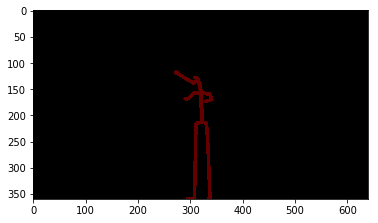

In [20]:
vectors_to_video(denormalized_output_position,output_path='/home/ubuntu/dance-to-beats/src/model/output_seq_gen.avi',frame_size=(640,360),begin_frame=0,end_frame=199)


In [21]:
#output_position = np.reshape(position_raw_stacked[13], (position_raw_stacked[0].shape[0], 25, 2))
#pos = denormalized(output_position)
#vectors_to_video(pos,output_path='/home/ubuntu/dance-to-beats/src/model/output_seq_gen.avi',frame_size=(640,360),begin_frame=0,end_frame=199)
